In [1]:
#LSTM caso 1: UNIVARIADO - CANTIDAD_VENTAS
import pyodbc
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')

In [2]:
# sql_server = """
# DRIVER={ODBC Driver 17 for SQL Server};
# server=192.168.1.235,1433;
# database=demo_prediccion;
# uid=sa;
# pwd=qwerty;
# Trusted_connection=yes;
# """

In [3]:
# sql_server = """
# DRIVER={ODBC Driver 17 for SQL Server};
# server=192.168.1.235,1433;
# database=AdventureWorksDW2022;
# uid=sa;
# pwd=qwerty;
# Trusted_connection=yes;
# """

In [4]:
sql_server = """
DRIVER={ODBC Driver 17 for SQL Server};
server=US3RN4M3;
database=AdventureWorksDW2022;
Trusted_connection=yes;
"""

In [5]:
# Se entrenará con todos los datos de las ventas menores al 2020
# query = """
# SELECT
# [F].[Fecha] AS fecha,
# SUM([H]. [cantidad]) AS TotalVentas
# FROM
# [demo_prediccion]. [dbo]. [hechos] AS [H]
# INNER JOIN [demo_prediccion]. [dbo]. [Dim_fechas] AS [f] ON [H].[id_DimFechas] = [F].[id]
# WHERE 
# [F].[Fecha] > '2016-12-31' AND [F].[Fecha] < '2020-01-01'
# GROUP BY [F].[Fecha]
# ORDER BY [F].[Fecha]
# """

In [6]:
# query = """
# SELECT CAST(f.OrderDate AS DATE) AS sales_date, CAST(SUM(f.SalesAmount) AS INT) AS TotalVentas FROM FactInternetSales AS f WHERE F.OrderDate < '2013-01-01' GROUP BY CAST(f.OrderDate AS DATE) ORDER BY CAST(f.OrderDate AS DATE) ASC;
# """

In [7]:
query = """
SELECT
    CAST(OrderDate AS DATE) AS Date
    ,YEAR([OrderDate]) AS [YEAR]
    ,MONTH([OrderDate]) AS [MONTH]
    ,DAY([OrderDate]) AS [Day]
    ,DATEPART(weekday, [OrderDate]) - 1 AS [DayOfWeek]
    ,CASE
        WHEN DATEPART(weekday, [OrderDate]) IN (7, 1) THEN 1
        ELSE 0
    END AS IsWeekend
    ,[ProductKey]
    ,Sum([OrderQuantity]) AS OrderQuantity
    ,Sum([UnitPrice]) AS UnitPrice
    ,Sum([UnitPriceDiscountPct]) As UnitPriceDiscountPct
    ,Sum([DiscountAmount]) AS DiscountAmount
    ,Sum([ProductStandardCost]) AS ProductStandardCost
    ,Sum([SalesAmount]) AS SalesAmount
    FROM [AdventureWorksDW2022].[dbo].[FactInternetSales]
    WHERE
    [FactInternetSales].OrderDate < '2013-12-01'
    group by YEAR([OrderDate]),MONTH([OrderDate]),DAY([OrderDate]),DATENAME(weekday,[OrderDate]),[OrderDate],[ProductKey]
    order by YEAR([OrderDate]) ASC,MONTH([OrderDate]) ASC,DAY([OrderDate]) ASC
"""

In [8]:
# query2="""
# SELECT
# [F].[Fecha] AS fecha,
# SUM([H]. [cantidad]) AS TotalVentas
# FROM
# [demo_prediccion]. [dbo]. [hechos] AS [H]
# INNER JOIN [demo_prediccion]. [dbo]. [Dim_fechas] AS [f] ON [H].[id_DimFechas] = [F].[id]
# WHERE 
# [F].[Fecha] > '2016-12-31' AND [F].[Fecha] < '2021-01-01'
# GROUP BY [F].[Fecha]
# ORDER BY [F].[Fecha]
# """

In [9]:
query2 = """
SELECT CAST(f.OrderDate AS DATE) AS sales_date, CAST(SUM(f.OrderQuantity) AS INT) AS TotalVentas FROM FactInternetSales AS f GROUP BY CAST(f.OrderDate AS DATE) ORDER BY CAST(f.OrderDate AS DATE) ASC;
"""

In [10]:
queryProducts = """
SELECT
    p.ProductKey,
    p.StandardCost,
    p.ListPrice AS Price
FROM
    DimProduct AS p
WHERE
    p.ProductKey IS NOT NULL 
	AND p.StandardCost IS NOT NULL
	AND p.ListPrice IS NOT NULL;
"""

In [11]:
#CONSTANTES

PASOS = 31
TRAINING_PERCENTAGE = 0.8
N_PREDICTIONS = 31
EPOCHS = 50
NEURONS = 31 #Mismo que el de pasos


#NOTAS DE ESTA PARTE: el número de pasos no es correlativo al No. de predicciones
#ya que, las predicciones pudieran ser de 61 días y el No. de pasos siempre serán 31, ya que bajo
#ese proceso se hizo el entrenamiento

In [12]:
#Opcion 1: Permitir que pueda ser modificada la sentencia, y mantener el try para evitar de que
# el programa se rompa
def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection

In [13]:
def set_index_datetime(data):
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

In [14]:
# split a multivariate sequence into samples
'''
En este método se pretende que pueda separar cada ventana deslizantes con las claves del producto
cada productKey tendrá su slidding window con sus propios time_steps 
'''
# def split_sequences(sequences, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequences)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the dataset
# 		if end_ix > len(sequences)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return np.array(X), np.array(y)

'\nEn este método se pretende que pueda separar cada ventana deslizantes con las claves del producto\ncada productKey tendrá su slidding window con sus propios time_steps \n'

In [15]:
'''
En este método se pretende que pueda separar cada ventana deslizantes con las claves del producto
cada productKey tendrá su slidding window con sus propios time_steps 
'''
def split_sequences(df, time_steps, features, target):
    #Separamos en dos grupos, X que contiene todos los features, y Y que contiene la
    X, y = [], []
    for _, grupo in df.groupby('ProductKey'):
        datos = grupo[features].values
        target_vals = grupo[target].values
        for i in range(len(datos) - time_steps):
            X.append(datos[i:i+time_steps])
            y.append(target_vals[i+time_steps])
    return np.array(X), np.array(y)

In [16]:
def tratamiento_datos(data, columns, features, target_col, productkeyIds,dataProduct):
    val = data.copy()
    val = val.reset_index()

    series_modified = []

    #obtener la fecha inicial
    for i, group in val.groupby('ProductKey'):

        #obtenemos el productKeyActual
        producK_ID = group['ProductKey'].iloc[0]

        #obtener la fecha inicial
        date_ini = group['Date'].min()

        #obtener la fecha final
        date_last = group['Date'].max()
        
        #determinamos el total de días que debería tener
        # dias = (date_last - date_ini).days

        #Comvertimos la columna 'Date' a datetime
        group['Date'] = pd.to_datetime(group['Date'], errors='coerce')

        #ordenamos la columna
        group = group.sort_values('Date')
        
        #filtramos y obtenemos los valores únicamente en el rango establecido
        group = group[(group['Date']>= pd.Timestamp(date_ini)) & (group['Date']<=pd.Timestamp(date_last))]

        #seteamos como index
        group_index = group.set_index('Date')

        #Creamos el rango que debería tener lo ya establecido
        days_corrected = pd.date_range(start=date_ini, end=date_last - pd.Timedelta(days=1), freq='D')

        #Reindexamos para poder garantizar continuidad (rellenamos los días faltantes)
        group_reindex = group_index.reindex(days_corrected)

        #Comprobamos, debe haber NaN o NA
        print(group_reindex)

        #PASO 2: RELLENAR EL RESTO DE COLUMNAS FALTANTES

        group_reindex = group_reindex.reset_index()

        #Rellenar columnas relacionado a la fecha
        group_reindex['YEAR'] = group_reindex['index'].dt.year
        group_reindex['MONTH'] = group_reindex['index'].dt.month
        group_reindex['Day'] = group_reindex['index'].dt.day
        group_reindex['DayOfWeek'] = group_reindex['index'].dt.dayofweek
        group_reindex['IsWeekend'] = group_reindex['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        #setear index
        group_reindex = group_reindex.set_index('index')

        #COLUMNA TARGET
        group_reindex[target_col] = group_reindex[target_col].fillna(0)

        #Obtenemos el precio unitario
        precioUNitario = dataProduct[dataProduct['ProductKey'] == producK_ID]['Price'].values[0]

        #obtenemos el envio
        precioEnvio = dataProduct[dataProduct['ProductKey'] == producK_ID]['StandardCost'].values[0]

        #PRECIO UNITARIO
        group_reindex['UnitPrice'] = group_reindex['UnitPrice'].fillna(0.0)

        #DESCUENTO UNITARIO
        group_reindex['UnitPriceDiscountPct'] = group_reindex['UnitPriceDiscountPct'].fillna(0.0)

        #DESCUENTO ACUMULADO
        group_reindex['DiscountAmount'] = group_reindex['DiscountAmount'].fillna(0)

        #PRECIO DE ENVÍO
        group_reindex['ProductStandardCost'] = group_reindex['ProductStandardCost'].fillna(0.0)

        #VENTAS
        group_reindex['SalesAmount'] = group_reindex['SalesAmount'].fillna(0.0)

        #AGREGAR NUEVAMENTE EL PRODUCTKEY
        group_reindex['ProductKey'] = producK_ID

        print(group_reindex)

        # Agregar la serie modificada a la lista
        series_modified.append(group_reindex)

    data_modified = pd.concat(series_modified)

    return data_modified

In [17]:
def create_x_y_train(data, columns, features, target_col):
    #creamos una copia de la data
    values = data.copy()

    # #obtenemos las features que si se podrán convertir a float32
    # features_list = list(features)
    # features_list = [col for col in features_list if col != 'ProductKey']

    # #Convertimos solamente las columnas que necesitamos a punto flotante
    # values[features_list] = values[features_list].astype('float32')
    
    # #generamos un escalador
    # scaler = MinMaxScaler(feature_range=(-1, 1))

    #escalamos las columnas necesarias
    # scaled = scaler.fit_transform(values[features_list])
    
    #===================================
    #Los escaladores son: 1 para la serie inicial, contemplando 12 columnas, 
    # uno para x con n_features, y otro para y con target
    #generamos un escalador para el tratamiento de los datos a algoritmo SLDW
    scaler = MinMaxScaler(feature_range=(-1, 1))

    #generamos un escalador para las features 'X'
    scaler_x = MinMaxScaler(feature_range=(-1,1))

    #generamos un escalador para las feature target 'Y'
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    
    # Convertimos las columnas a punto flotante
    values = values.astype('float32')

    #escalamos los valores para sldw
    scaled = scaler.fit_transform(values)

    #Esta parte nos permitirá solamente obtener los escaladores para predicciones

    #obtenemos la lista de las features
    features_list = list(features)

    #Escalamos features_n 'X'
    scaler_x.fit_transform(values[features_list])

    #Escalamos target 'Y'
    #tendremos que hacer un escalador solamente para la columna target que servirá luego para hacer predicciones
    scaler_y.fit_transform(values[[target_col]]) 

    #Convertimos a dataframe
    df = pd.DataFrame(scaled, columns=columns)
    
    X, Y = split_sequences(df, PASOS, features, target_col)
    
    # values = reframed.values
    print(f'esta es X: {X.shape}')
    print(f'Esta es Y {Y.shape}')
    
    print("total_datos:",len(values))
    #debemos obtener el total de datos de entrenamiento
    n_train_samples = int(len(X) * TRAINING_PERCENTAGE)
    X_train, X_val = X[:n_train_samples], X[n_train_samples:]
    y_train, y_val = Y[:n_train_samples], Y[n_train_samples:]

    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_val: {X_val.shape}, y_val: {y_val.shape}")

    return X_train, y_train, X_val, y_val, df, scaler_x, scaler_y, scaler

In [18]:
def train_model(x_train, y_train, x_val, y_val, df, model, target_col):
    history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(x_val, y_val),verbose=2,shuffle=False)
    # # Preparar x_test para el modelo LSTM
    # x_test = ultimosDias.values.reshape((1, PASOS, 11))  # Forma (1, PASOS, n_features)

    # print(x_test.shape)

    # Devolver el modelo entrenado y x_test
    return model

In [19]:
def newModelLSTM(n_features):
    dropout_rate = 0.2
    model = Sequential()
    model.add(LSTM(NEURONS, activation='tanh', input_shape=(PASOS, n_features)))
    # model.add(LSTM(NEURONS, activation='relu', input_shape=(PASOS, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Salida univariada
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model

In [20]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

In [21]:
def predictionsENG(n_predictions,df, productsIds, model, time_steps,features, scaler_x, scaler_y, target_col, lastDay):
    tt_predictions = {}
    #eliminamos la columna 'Y'
    df = df.reset_index()
    # df = df.drop(target_col,axis=1)
    # print(df.columns)
    # print(len(df.columns))
    # print(len(features))
    # print(scaler_x.n_features_in_)

    sldw = []

    #Antes, deberemos comprobar que registros si tienen los timeSteps disponibles
    for productID in productsIds:
        print("iniciando con el producto: ",productID)
        # Filtrar los datos para el producto actual y hacemos una copia para que no afecte el original
        serie = df[df['ProductKey'] == productID].copy()

        # Verificar si hay suficientes datos
        # if len(serie) < time_steps:
        #     print(f"Advertencia: El producto {productID} no tiene suficientes datos ({len(serie)} < {time_steps})")
        #     print("iniciando forma")
        #     continue  # Saltar al siguiente producto

        #convertir la columna date a Datetime
        serie['Date'] = pd.to_datetime(serie['Date'], errors='coerce')

        #Ordenamos las fechas en orden cronológico de lo registrado por las ventas ¿
        serie = serie.sort_values('Date')

        #Obtener la última venta realizada (puede venir de la metadata)
        lastDay = pd.to_datetime(lastDay)

        #generar los 31 días anteriores a la última fecha de entrenamiento del modelo
        firstDay = lastDay - pd.Timedelta(days=31)

        # Crear rango fijo de fechas (últimos 31 días antes de la fecha de predicción)
        precitions_days = pd.date_range(start=firstDay, end=lastDay - pd.Timedelta(days=1), freq='D')

        # Reindexar para garantizar continuidad temporal (rellenar días faltantes)
        serie_reindex = serie.reindex(precitions_days)

        #En teoría ya hay las columnas, solo es rellenar con las que hacen falta
        serie_reindex['YEAR'] = serie_reindex['Date'].dt.year
        serie_reindex['MONTH'] = serie_reindex['Date'].dt.month
        serie_reindex['Day'] = serie_reindex['Date'].dt.day
        serie_reindex['DayOfWeek'] = serie_reindex['Date'].dt.dayofweek
        serie_reindex['IsWeekend'] = serie_reindex['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        #lo seteamos como index
        # serie = serie.set_index('Date')
        
        # Rellenar valores faltantes de la columna target con 0
        serie_reindex[target_col] = serie_reindex[target_col].fillna(0)

        #Rellenar el precio unitario
        serie_reindex['UnitPrice'] = serie_reindex['UnitPrice'].fillna(0)

        #Rellenar descuento unitario
        serie_reindex['UnitPriceDiscountPct'] = serie_reindex['UnitPriceDiscountPct'].fillna(0.0)

        #Rellenar descuento acumulado
        serie_reindex['DiscountAmount'] = serie_reindex['DiscountAmount'].fillna(0)

        serie_reindex['ProductStandardCost'] = serie_reindex['ProductStandardCost'].fillna(0)

        serie_reindex['SalesAmount'] = serie_reindex['SalesAmount'].fillna(0)
        # Otras columnas como precio o descuento: rellenar con último valor conocido
        # for col in features:
        #     if col in serie_reindex.columns:
        #         serie_reindex[col] = serie_reindex[col].fillna(method='ffill')
        
        # Agregar nuevamente el ProductKey
        serie_reindex['ProductKey'] = productID

        #eliminar la columna de order quantity
        serie_reindex = serie_reindex.drop(target_col, axis=1)

        #hasta este punto nos aseguramos de que todos los datos tienen 31 pasos en el tiempo
        #fin del primer paso

        #============= PASO 2=============
        #Hacerlo pasar por series tu supervised para hacer la predicción
        lastDaysPID = serie_reindex.copy()

        #eliminamos datetime
        lastDaysPID = lastDaysPID.drop(['Date'], axis=1)

        #convertimos a punto flotante
        lastDaysPID = lastDaysPID.astype('float32')

        #devolvemos el formato
        lastDaysPID['Date'] = serie_reindex['Date']

        #seteamos como index
        lastDaysPID =  lastDaysPID.set_index('Date')

        #escalamos los datos 
        lastDaysPID_scaled = scaler_x.transform(lastDaysPID)

        print(lastDaysPID_scaled.shape)
        
        #hay que dar la forma para datos de entrada del modelo
        x_input = lastDaysPID_scaled.reshape((1, time_steps, len(features)))

        #hacemos la preparación de las ventas con predicciones multistep
        predictions = []

        print("iniciando prediccion...")
        for i in range(n_predictions):

            #prediccion
            prediction = model.predict(x_input)

            #Desescalar la prediccion
            original_prediction = scaler_y.inverse_transform(prediction)

            np.nan_to_num(original_prediction, nan=0)
            
            original_prediction = original_prediction.astype(int)

            #convertir a entero
            # try:
            #     original_prediction = original_prediction.astype(int)
            # except Exception as e: 
            #     np.nan_to_num(original_prediction, nan=0)

            #guardar la prediccion
            predictions.append(original_prediction[0][0])

            #actualizamos el valor de la nueva prediccion
            x_input = addNewValue(x_input, prediction[0])
        print("finalizando prediccion...")

        print(predictions)
        
        #guardamos las predicciones
        tt_predictions[productID] = predictions



    return tt_predictions


        # sldw.append(serie_reindex)
        
        # Mostrar información del producto
        # print(f"Producto: {productID}")
        # print(serie.tail(PASOS)) 
    # df_ventanas = pd.concat(sldw)
    # print(df_ventanas)
    

    #Por cada producto registrado tendremos que generar su propio forecasting
    # for productID in productsIds:
    #     #por cada producto habrá que generar un time_steps
    #     serie = df[df['ProductKey'] == productID].sort_values('Date')
    #     # 2. Verificar que tenga suficientes datos
    #     if len(serie) < time_steps:
    #         raise ValueError(f"El producto {productID} no tiene suficientes datos ({len(serie)} < {time_steps})")
    #     print(serie)
    #     ultimosDias = serie[features].values[-time_steps:]
    #     print(ultimosDias)
        # ultimos_escalados = scaler_x.transform(ultimosDias)
        # x_input = ultimos_escalados.reshape((1, time_steps, len(features)))
        # print(x_input.shape)
    # the data is more than 'PASOS'?
    # if len(data) < PASOS:
    #     raise ValueError("Los datos no tienen suficientes filas para preparar x_test.")
    
    # Obtener los últimos datos para predicciones futuras
    # ultimosDias = df.iloc[-PASOS:]  # Últimos PASOS días
    # values = ultimosDias.values.astype('float32')

    # Escalar los datos con el escalador ya ajustado
    # scaled = scaler.transform(values)

    #===============================
    #copiar el dataframe
    # ltstp = df.copy()

    # #eliminamos la columna que se va a predecir
    # ltstp = ltstp.drop(columns=[target_col])

    # #cargamos solamente los últimos 31 time_steps
    # ltstp = ltstp.iloc[-PASOS:]

    # print(ltstp.shape)

    # #cargamos nuestro timestep
    # x_test = ltstp.values.reshape((1,PASOS,11))

    # print(x_test.shape)

In [22]:
def addNewValue(x_test, nuevoValor):
    x_test[0, :-1, :] = x_test[0, 1:, :]
    x_test[0, -1, :] = nuevoValor
    return x_test

In [23]:
#core
with get_sqlconnection(sql_server) as cursor: 
    prepData = pd.read_sql_query(query,cursor)
    historyData = pd.read_sql_query(query2, cursor)

    

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_24424\1245306699.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prepData = pd.read_sql_query(query,cursor)
C:\Users\JoCel\AppData\Local\Temp\ipykernel_24424\1245306699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  historyData = pd.read_sql_query(query2, cursor)


In [24]:
    prepData

,Date,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount
0,2010-12-29,2010,12,29,3,0,310,1,3578.2700,0.0,0.0,2171.2942,3578.2700
1,2010-12-29,2010,12,29,3,0,336,1,699.0982,0.0,0.0,413.1463,699.0982
2,2010-12-29,2010,12,29,3,0,346,3,10199.9700,0.0,0.0,5736.4632,10199.9700
3,2010-12-30,2010,12,30,4,0,310,1,3578.2700,0.0,0.0,2171.2942,3578.2700
4,2010-12-30,2010,12,30,4,0,311,1,3578.2700,0.0,0.0,2171.2942,3578.2700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21271,2013-11-30,2013,11,30,6,1,589,1,769.4900,0.0,0.0,419.7784,769.4900
21272,2013-11-30,2013,11,30,6,1,591,1,564.9900,0.0,0.0,308.2179,564.9900
21273,2013-11-30,2013,11,30,6,1,599,1,539.9900,0.0,0.0,294.5797,539.9900
21274,2013-11-30,2013,11,30,6,1,604,2,1079.9800,0.0,0.0,687.2992,1079.9800


In [25]:
    print(len(prepData.columns))

13


In [26]:
    copyprepData = prepData
    copyprepData = set_index_datetime(copyprepData)
    historyData = set_index_datetime(historyData)

In [27]:
    prepData

,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount
Date,,,,,,,,,,,,
2010-12-29,2010,12,29,3,0,310,1,3578.2700,0.0,0.0,2171.2942,3578.2700
2010-12-29,2010,12,29,3,0,336,1,699.0982,0.0,0.0,413.1463,699.0982
2010-12-29,2010,12,29,3,0,346,3,10199.9700,0.0,0.0,5736.4632,10199.9700
2010-12-30,2010,12,30,4,0,310,1,3578.2700,0.0,0.0,2171.2942,3578.2700
2010-12-30,2010,12,30,4,0,311,1,3578.2700,0.0,0.0,2171.2942,3578.2700
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-30,2013,11,30,6,1,589,1,769.4900,0.0,0.0,419.7784,769.4900
2013-11-30,2013,11,30,6,1,591,1,564.9900,0.0,0.0,308.2179,564.9900
2013-11-30,2013,11,30,6,1,599,1,539.9900,0.0,0.0,294.5797,539.9900


In [28]:
    #ordenar por ProductKey
    df = prepData.sort_values(['ProductKey', 'Date'])
    dfg = df.copy()
    #obtenemos la lista de los elementos
    productKeyIds = dfg['ProductKey'].unique()
    #convertir ProductKey a String
    df['ProductKey'] = df['ProductKey'].astype(str)

    #label encoder
    le = LabelEncoder()
    #Codificamos el productKey a labelEncoder
    df['ProductKey'] = le.fit_transform(df['ProductKey'])

In [29]:
    productKeyIds

array([214, 217, 222, 225, 228, 231, 234, 237, 310, 311, 312, 313, 314,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
       389, 390, 463, 465, 467, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       528, 529, 530, 535, 536, 537, 538, 539, 540, 541, 560, 561, 562,
       563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575,
       576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588,
       589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 604,
       605, 606])

In [30]:
    print(len(productKeyIds))

158


In [31]:
    #obtenemos las variables disponibles
    all_columns = df.columns.copy()
    #Columna que deseamos predecir
    target_col = 'OrderQuantity'
    #generamos una lista de las 'x_features'
    features = df.columns.copy()
    #eliminamos la columna target
    features = features.drop(target_col)

In [32]:
    df

,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount
Date,,,,,,,,,,,,
2012-12-28,2012,12,28,5,0,0,2,69.98,0.0,0.0,26.1726,69.98
2012-12-29,2012,12,29,6,1,0,2,69.98,0.0,0.0,26.1726,69.98
2012-12-30,2012,12,30,0,1,0,2,69.98,0.0,0.0,26.1726,69.98
2012-12-31,2012,12,31,1,0,0,4,139.96,0.0,0.0,52.3452,139.96
2013-01-01,2013,1,1,2,0,0,2,69.98,0.0,0.0,26.1726,69.98
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-22,2013,11,22,5,0,157,1,539.99,0.0,0.0,343.6496,539.99
2013-11-25,2013,11,25,1,0,157,1,539.99,0.0,0.0,343.6496,539.99
2013-11-26,2013,11,26,2,0,157,1,539.99,0.0,0.0,343.6496,539.99


In [33]:
    #Switch the format on days or months
    #nota, acualmente los datos son filtrados con respecto a solo si son en  formato de día o de mes,
    #en LSTM, que incluye  datos en horarios, se tendría que modificar esta parte
    first_day = copyprepData.index.min() + timedelta(days=1)
    last_day = copyprepData.index.max() + timedelta(days=1)
    future_days = [last_day + timedelta(days=i) for i in range(N_PREDICTIONS)]
    for i in range(len(future_days)):
        future_days[i] = str(future_days[i])[:10]

In [34]:
    #De momento solamente será la fecha
    future_data = pd.DataFrame(future_days, columns=['fecha'])

    #obtenemos el total de features con las que se hará el entrenamiento del modelo
    n_features = int(len(features.values))
    prepData.columns
    print(n_features)

11


In [35]:
    prepData = df.copy()

In [36]:
    #antes de iniciar, hacer una consulta para obtener mediante productKey, el standar cost y el precio del producto
    with get_sqlconnection(sql_server) as cursor: 
        dataProduct = pd.read_sql_query(queryProducts,cursor)

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_24424\4080135074.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataProduct = pd.read_sql_query(queryProducts,cursor)


In [37]:
    # Filtrar productos que están en la serie temporal
    dataProduct = dataProduct[dataProduct['ProductKey'].isin(productKeyIds)]
    dataProduct

,ProductKey,StandardCost,Price
2,214,13.0863,34.99
5,217,13.0863,34.99
10,222,13.0863,34.99
13,225,6.9223,8.99
16,228,38.4923,49.99
...,...,...,...
387,599,294.5797,539.99
388,600,294.5797,539.99
392,604,343.6496,539.99
393,605,343.6496,539.99


In [38]:
    #Haremos tratamiento de datos
    data_trat = tratamiento_datos(dfg, all_columns,features, target_col,productKeyIds,dataProduct)

              YEAR  MONTH   Day  DayOfWeek  IsWeekend  ProductKey  \
2012-12-28  2012.0   12.0  28.0        5.0        0.0       214.0   
2012-12-29  2012.0   12.0  29.0        6.0        1.0       214.0   
2012-12-30  2012.0   12.0  30.0        0.0        1.0       214.0   
2012-12-31  2012.0   12.0  31.0        1.0        0.0       214.0   
2013-01-01  2013.0    1.0   1.0        2.0        0.0       214.0   
...            ...    ...   ...        ...        ...         ...   
2013-11-25  2013.0   11.0  25.0        1.0        0.0       214.0   
2013-11-26  2013.0   11.0  26.0        2.0        0.0       214.0   
2013-11-27  2013.0   11.0  27.0        3.0        0.0       214.0   
2013-11-28  2013.0   11.0  28.0        4.0        0.0       214.0   
2013-11-29  2013.0   11.0  29.0        5.0        0.0       214.0   

            OrderQuantity  UnitPrice  UnitPriceDiscountPct  DiscountAmount  \
2012-12-28            2.0      69.98                   0.0             0.0   
2012-12-29     

In [39]:
    data_trat

,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount
index,,,,,,,,,,,,
2012-12-28,2012,12,28,4,0,214,2.0,69.98,0.0,0.0,26.1726,69.98
2012-12-29,2012,12,29,5,1,214,2.0,69.98,0.0,0.0,26.1726,69.98
2012-12-30,2012,12,30,6,1,214,2.0,69.98,0.0,0.0,26.1726,69.98
2012-12-31,2012,12,31,0,0,214,4.0,139.96,0.0,0.0,52.3452,139.96
2013-01-01,2013,1,1,1,0,214,2.0,69.98,0.0,0.0,26.1726,69.98
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-23,2013,11,23,5,1,606,0.0,0.00,0.0,0.0,0.0000,0.00
2013-11-24,2013,11,24,6,1,606,0.0,0.00,0.0,0.0,0.0000,0.00
2013-11-25,2013,11,25,0,0,606,1.0,539.99,0.0,0.0,343.6496,539.99


In [40]:
    # #creamos un modelo
    model = newModelLSTM(n_features)
    x_train, y_train, x_val, y_val, df, scaler_x, scaler_y, scaler = create_x_y_train(data_trat, all_columns ,features, target_col)
    # x_train, y_train, x_val, y_val, df, scaler_x, scaler_y, scaler = create_x_y_train(prepData, all_columns ,features, target_col)

c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 31)             │         5,332 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,364 (20.95 KB)

 Trainable params: 5,364 (20.95 KB)

 Non-trainable params: 0 (0.00 B)

esta es X: (48151, 31, 11)
Esta es Y (48151,)
total_datos: 53049
Forma de X_train: (38520, 31, 11), y_train: (38520,)
Forma de X_val: (9631, 31, 11), y_val: (9631,)


In [41]:
    model  = train_model(x_train, y_train,x_val, y_val,df,model, target_col)

Epoch 1/50
1204/1204 - 6s - 5ms/step - loss: 0.0505 - mae: 0.1529 - val_loss: 0.0040 - val_mae: 0.0388
Epoch 2/50
1204/1204 - 5s - 4ms/step - loss: 0.0349 - mae: 0.1232 - val_loss: 0.0039 - val_mae: 0.0398
Epoch 3/50
1204/1204 - 5s - 4ms/step - loss: 0.0341 - mae: 0.1178 - val_loss: 0.0040 - val_mae: 0.0395
Epoch 4/50
1204/1204 - 5s - 4ms/step - loss: 0.0333 - mae: 0.1146 - val_loss: 0.0040 - val_mae: 0.0397
Epoch 5/50
1204/1204 - 5s - 4ms/step - loss: 0.0329 - mae: 0.1121 - val_loss: 0.0040 - val_mae: 0.0401
Epoch 6/50
1204/1204 - 5s - 4ms/step - loss: 0.0328 - mae: 0.1114 - val_loss: 0.0041 - val_mae: 0.0400
Epoch 7/50
1204/1204 - 5s - 4ms/step - loss: 0.0325 - mae: 0.1109 - val_loss: 0.0043 - val_mae: 0.0390
Epoch 8/50
1204/1204 - 5s - 4ms/step - loss: 0.0324 - mae: 0.1102 - val_loss: 0.0048 - val_mae: 0.0389
Epoch 9/50
1204/1204 - 5s - 4ms/step - loss: 0.0325 - mae: 0.1104 - val_loss: 0.0038 - val_mae: 0.0465
Epoch 10/50
1204/1204 - 4s - 4ms/step - loss: 0.0329 - mae: 0.1108 - val_

In [42]:
    df

,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount
0,0.333374,1.000000,0.800000,0.333333,-1.0,-1.0,-0.826087,-0.992377,-1.0,-1.0,-0.995178,-0.992377
1,0.333374,1.000000,0.866667,0.666667,1.0,-1.0,-0.826087,-0.992377,-1.0,-1.0,-0.995178,-0.992377
2,0.333374,1.000000,0.933333,1.000000,1.0,-1.0,-0.826087,-0.992377,-1.0,-1.0,-0.995178,-0.992377
3,0.333374,1.000000,1.000000,-1.000000,-1.0,-1.0,-0.652174,-0.984754,-1.0,-1.0,-0.990357,-0.984754
4,1.000000,-1.000000,-1.000000,-0.666667,-1.0,-1.0,-0.826087,-0.992377,-1.0,-1.0,-0.995178,-0.992377
...,...,...,...,...,...,...,...,...,...,...,...,...
53044,1.000000,0.818182,0.466667,0.666667,1.0,1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000
53045,1.000000,0.818182,0.533333,1.000000,1.0,1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000
53046,1.000000,0.818182,0.600000,-1.000000,-1.0,1.0,-0.913043,-0.941177,-1.0,-1.0,-0.936692,-0.941177
53047,1.000000,0.818182,0.666667,-0.666667,-1.0,1.0,-0.913043,-0.941177,-1.0,-1.0,-0.936692,-0.941177


In [43]:
    dfg

,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount
Date,,,,,,,,,,,,
2012-12-28,2012,12,28,5,0,214,2,69.98,0.0,0.0,26.1726,69.98
2012-12-29,2012,12,29,6,1,214,2,69.98,0.0,0.0,26.1726,69.98
2012-12-30,2012,12,30,0,1,214,2,69.98,0.0,0.0,26.1726,69.98
2012-12-31,2012,12,31,1,0,214,4,139.96,0.0,0.0,52.3452,139.96
2013-01-01,2013,1,1,2,0,214,2,69.98,0.0,0.0,26.1726,69.98
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-22,2013,11,22,5,0,606,1,539.99,0.0,0.0,343.6496,539.99
2013-11-25,2013,11,25,1,0,606,1,539.99,0.0,0.0,343.6496,539.99
2013-11-26,2013,11,26,2,0,606,1,539.99,0.0,0.0,343.6496,539.99


In [44]:
    dataProduct

,ProductKey,StandardCost,Price
2,214,13.0863,34.99
5,217,13.0863,34.99
10,222,13.0863,34.99
13,225,6.9223,8.99
16,228,38.4923,49.99
...,...,...,...
387,599,294.5797,539.99
388,600,294.5797,539.99
392,604,343.6496,539.99
393,605,343.6496,539.99


In [45]:
    #Es recomendable tener el precio de cada producto actualizado, ya que será necesario para recrear las series temporales de cada producto    
    # with get_sqlconnection

    tt_predictions = {}
    #eliminamos la columna 'Y'
    df = dfg.reset_index()
    # df = df.drop(target_col,axis=1)
    # print(df.columns)
    # print(len(df.columns))
    # print(len(features))
    # print(scaler_x.n_features_in_)

    sldw = []

    #Antes, deberemos comprobar que registros si tienen los timeSteps disponibles
    for productID in productKeyIds:
        # print("iniciando con el producto: ",productID)
        # Filtrar los datos para el producto actual y hacemos una copia para que no afecte el original
        serie = df[df['ProductKey'] == productID].copy()

        #Obtener la última venta realizada (puede venir de la metadata)
        lastDay = pd.to_datetime(last_day)

        #generar los 31 días anteriores a la última fecha de entrenamiento del modelo
        firstDay = lastDay - pd.Timedelta(days=32)

        #convertir la columna date a Datetime
        serie['Date'] = pd.to_datetime(serie['Date'], errors='coerce')

        #Ordenamos las fechas en orden cronológico de lo registrado por las ventas
        serie = serie.sort_values('Date')

        #Tomamos solo las ventas que esten en ese rango
        #Filtramos los valores
        serie = serie[(serie['Date'] >= pd.Timestamp(first_day)) & (serie['Date'] <= pd.Timestamp(lastDay))]

        # Crear rango fijo de fechas (últimos 31 días antes de la fecha de predicción)
        precitions_days = pd.date_range(start=firstDay, end=lastDay - pd.Timedelta(days=1), freq='D')

        #setear el index de serie
        serie_indexada = serie.set_index('Date')

        # Reindexar para garantizar continuidad temporal (rellenar días faltantes)
        serie_reindex = serie_indexada.reindex(precitions_days)

        serie_reindex = serie_reindex.reset_index()

        #En teoría ya hay las columnas, solo es rellenar con las que hacen falta
        serie_reindex['YEAR'] = serie_reindex['index'].dt.year
        serie_reindex['MONTH'] = serie_reindex['index'].dt.month
        serie_reindex['Day'] = serie_reindex['index'].dt.day
        serie_reindex['DayOfWeek'] = serie_reindex['index'].dt.dayofweek
        serie_reindex['IsWeekend'] = serie_reindex['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        #lo seteamos como index
        # serie_reindex = serie_reindex.set_index('index')
        
        # Rellenar valores faltantes de la columna target con 0
        serie_reindex[target_col] = serie_reindex[target_col].fillna(0)

        #Obtenemos el precio unitario
        precioUNitario = dataProduct[dataProduct['ProductKey'] == productID]['Price'].values[0]

        #obtenemos el envio
        precioEnvio = dataProduct[dataProduct['ProductKey'] == productID]['StandardCost'].values[0]

        #Rellenar el precio unitario
        serie_reindex['UnitPrice'] = serie_reindex['UnitPrice'].fillna(0.0)

        #Rellenar descuento unitario
        serie_reindex['UnitPriceDiscountPct'] = serie_reindex['UnitPriceDiscountPct'].fillna(0.0)

        #Rellenar descuento acumulado
        serie_reindex['DiscountAmount'] = serie_reindex['DiscountAmount'].fillna(0)

        #Rellenar el precio de envío
        serie_reindex['ProductStandardCost'] = serie_reindex['ProductStandardCost'].fillna(0.0)

        #rellenar las ventas 
        serie_reindex['SalesAmount'] = serie_reindex['SalesAmount'].fillna(0.0)
        
        # Agregar nuevamente el ProductKey
        serie_reindex['ProductKey'] = productID

        #guardamos el archivo generado en un csv
        # serie_reindex.to_csv(f'serie_product_{productID}.csv', index=False)

        #hasta este punto nos aseguramos de que todos los datos tienen 31 pasos en el tiempo + 1 dato que servirá para generar el sliddingo window
        #fin del primer paso

        #============= PASO 2=============
        #Hacerlo pasar por series tu supervised para hacer la predicción
        lastDaysPID = serie_reindex.copy()

        # #eliminamos datetime
        lastDaysPID = lastDaysPID.drop(['index'], axis=1)

        # #convertimos a punto flotante
        lastDaysPID = lastDaysPID.astype('float32')

        # #devolvemos el formato
        lastDaysPID['index'] = serie_reindex['index']

        # #seteamos como index
        lastDaysPID =  lastDaysPID.set_index('index')

        lastDaysPID_scaled = scaler.fit_transform(lastDaysPID)
        
        #lo convertimos a un dataframe
        lastDaysPID_scaled_1 = pd.DataFrame(lastDaysPID_scaled, columns=all_columns)

        #Creamos los slidding window
        X,_ = split_sequences(lastDaysPID_scaled_1, PASOS, features, target_col)

        #escalamos los datos 
        x_input = X[-1].reshape((1, PASOS, len(features)))


        #hacemos la preparación de las ventas con predicciones multistep
        predictions = []
        for i in range(N_PREDICTIONS):
            prediction = model.predict(x_input)
            original_prediction = scaler_y.inverse_transform(prediction)
            original_prediction = original_prediction.astype(int)
            predictions.append(original_prediction[0][0])
            x_input = addNewValue(x_input, prediction[0])
        # #guardamos las predicciones
        tt_predictions[productID] = predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [49]:
    
    #============= PASO 3 ===============
    #Hacer el cálculo y suma de todos los prodúctos vendidos y cuantos se vendieron por día

    # Crear un rango de fechas basado en el número de predicciones
    days = pd.date_range(start=last_day, periods=N_PREDICTIONS, freq='D')

    #iniciar un dataframe que almacene las predicciones diarias
    general_day_predictions = pd.DataFrame({'Date':days, 'OrderQuantity':0})

    #sumar las predicciones de todos los productos para cada día
    for productID, predictions in tt_predictions.items():
        general_day_predictions['OrderQuantity'] += predictions

In [50]:
    print(general_day_predictions)

         Date  OrderQuantity
0  2013-12-01             40
1  2013-12-02             10
2  2013-12-03              0
3  2013-12-04              0
4  2013-12-05              0
5  2013-12-06              0
6  2013-12-07              0
7  2013-12-08              0
8  2013-12-09              0
9  2013-12-10              0
10 2013-12-11              0
11 2013-12-12              0
12 2013-12-13              0
13 2013-12-14              0
14 2013-12-15              0
15 2013-12-16              0
16 2013-12-17              0
17 2013-12-18              0
18 2013-12-19              0
19 2013-12-20              0
20 2013-12-21              0
21 2013-12-22              0
22 2013-12-23              0
23 2013-12-24              0
24 2013-12-25              0
25 2013-12-26              0
26 2013-12-27              0
27 2013-12-28              0
28 2013-12-29              0
29 2013-12-30              0
30 2013-12-31              0


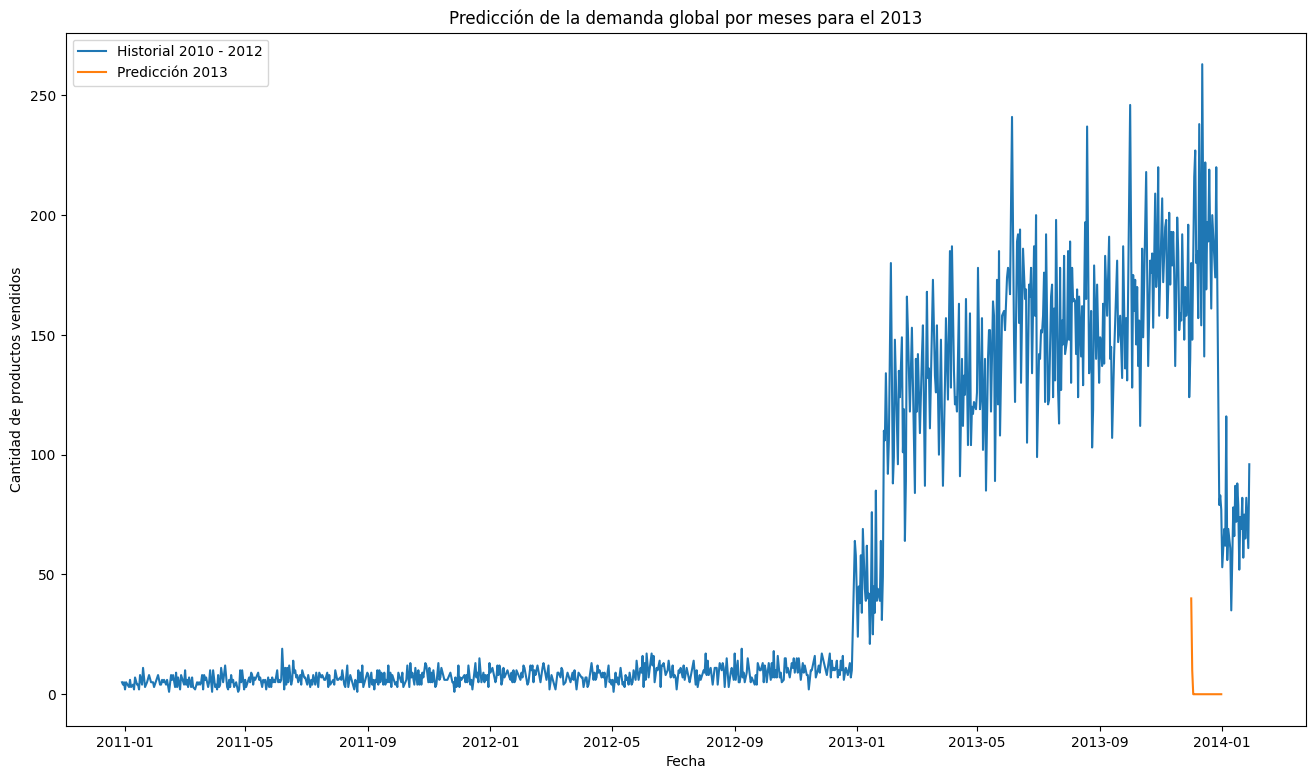

In [48]:
    future_data = set_index_datetime(general_day_predictions)
    prepData = historyData
    prepData.index = pd.to_datetime(historyData.index)
    future_data.index = pd.to_datetime(future_data.index)
    plt.plot(prepData.index, prepData['TotalVentas'],label='Historial {p0} - {p1}'.format(p0=str(first_day.year), p1= str(last_day.year-1)))
    plt.plot(future_data.index, future_data['OrderQuantity'],label='Predicción {p0}'.format(p0=str(last_day.year)))
    # xtics = data.index.union(future_data.index)[::10]

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Predicción de la demanda global por meses para el {p0}'.format(p0=str(last_day.year)))



    plt.legend()
    plt.show()